## Visualisation of High Dimensional Time Series Pollution Data

This notebook explores the visualisation of time series pollution data for the city of London from 2023 to 2025. Multiple visualisations and grouping techniques are utilized to extract meaningful insight from this dataset. Data is aggregated into 4 temporal categories: hourly, monthly, quarterly, and seasonal.

##### Datasets:
- https://www.kaggle.com/datasets/youssefelebiary/global-air-quality-2023-6-cities
- https://www.kaggle.com/datasets/youssefelebiary/air-quality-2024
- https://www.kaggle.com/datasets/youssefelebiary/global-air-quality-2025-6-cities

In [6]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import plotly.io as pio
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

### Setup
An analysis of the dataset shows that approximately 80% of the CO₂ feature contains missing (NaN) values; therefore, this column was removed.

In [7]:
london = pd.read_csv("./data/years/london_2023_to_2025.csv")
london = london.drop(columns=["CO2"]) ##Dropped because less than 80% of it's data in NaN

london["Date"] = pd.to_datetime(london["Date"])
long_london = london.copy()
long_london.head()


,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,AQI
0,2023-01-01 00:00:00+00:00,London,125.0,6.1,2.2,67.0,5.6,10.4,26.800001
1,2023-01-01 01:00:00+00:00,London,132.0,7.8,1.9,68.0,5.5,8.7,27.200000
2,2023-01-01 02:00:00+00:00,London,134.0,5.6,2.1,68.0,5.6,12.4,27.200000
3,2023-01-01 03:00:00+00:00,London,130.0,4.9,2.0,70.0,5.8,13.2,28.000000
4,2023-01-01 04:00:00+00:00,London,131.0,5.6,2.2,70.0,5.8,15.0,28.000000


#### Table Transformation
The hour is extracted from the date column and the data is grouped into four-hour intervals. The dataframe is then transformed from a wide format to a long format, retaining only the following pollutant features: CO, NO₂, SO₂, O₃, PM2.5, and PM10.

In [8]:
long_london["hour"] = long_london["Date"].dt.hour

long_london["time_range"] = pd.cut(
    long_london["hour"],
    bins=[0, 4, 8, 12, 16, 20, 24],
    right = False,
    labels=["0-4", "4-8", "8-12", "12-16", "16-20", "20-24"]
)

features = ["CO", "NO2", "SO2", "O3", "PM2.5", "PM10"]
long_london = long_london.melt(
    id_vars=["Date", "time_range"],
    value_vars=features,
    var_name="pollutant",
    value_name="value"
)


In [9]:
app = Dash(__name__)

app.layout = html.Div([
    html.H2("Hourly Pollutant Distribution"),

    dcc.Dropdown(
        id="feature-dropdown",
        options=[{"label": s, "value": s} for s in features],
        value="CO",
        clearable=False
    ),

    dcc.Graph(id="features-hourly-breakdown")
])


@app.callback(
    Output("features-hourly-breakdown", "figure"),
    Input("feature-dropdown", "value")
)
def update_plot(selected_feature):

    df = long_london[long_london["pollutant"] == selected_feature]

    fig = px.strip(
        df,
        x="time_range",
        y="value",
        title=f"{selected_feature} Distribution by 4-Hour Time Ranges",
    )

    fig.update_layout(
        xaxis_title="Time Range (hours)",
        yaxis_title=selected_feature,
        showlegend=False
    )

    

    return fig


if __name__ == "__main__":
    app.run(debug=True, port=8051)


The strip plot above illustrates the concentration of multiple pollutants across six four hour time intervals with each point representing an hourly measurement. 

- **CO:** Higher variability and more frequent high level outliers are observed during the 8 - 12 and 20 - 24 intervals. This suggests an increase in CO emissions in the morning and the late evening hours. In contrast 12 - 16 show a more compact distribution, indicating relatively stable emissions during midday.
- **NO₂:** Higher variability and higher concentration are observed during periods of 20 - 24 and 16 - 20. This suggest higher emissions fluctuations during the late afternoon to very early morning hours. While the midday interval(12 - 16) exhibits a more compact distribution and relatively stable emission rate.
- **SO₂:** Remains very low throughout all intervals with icrease variability and occasional spikes during the early morning(8-12) to late afternoons(20 - 24). While midday interval(12-16) suggest more stable SO₂ concentration. This suggests that SO₂ emissions are largely episodic and are not consistent in their elevation.
- **O₃:** Low values are observed during nighttime and early morning periods, while concentrations increase significantly during midday and afternoon hours, particularly between 12–16 and 16–20. This trend reflects the photochemical formation of ozone under daylight conditions.
- **PM2.5:** concentrations are elevated during the morning (4–8 and 8–12) and late evening (20–24) periods, with reduced concentrations and variability during midday (12–16). This pattern indicats large concentration of particulate matter during periods of high emission and limited atmospheric dispersion. This is followed by a sharp decrease during daylight hours.
- **PM10:** Trends higher and more variable during the morning (4–12) and late evening (20–24) periods, while lower and more stable concentrations are observed during midday (12–16).This pattern indicates that PM10 level are influenced greatly by traffic-related resuspension and human activity, similar to PM2.5 atomospheric mixing during daylight hours contribute to decrease in concentration. 

### Monthly Scatter Plot Faceted by Year

In [10]:
long_london["Year"] = long_london["Date"].dt.year
long_london["Month"] = long_london["Date"].dt.month_name()
long_london["MonthNum"] = long_london["Date"].dt.month
long_london_avg = (
    long_london
    .set_index("Date")
    .groupby(["pollutant", "Year", "MonthNum"])["value"]
    .resample("ME")
    .mean()
    .reset_index()
)

long_london_avg["Month"] = long_london_avg["Date"].dt.month_name()
px.scatter(long_london_avg, x="Month", y="value", facet_col="Year", color="pollutant")

### Quarterly Average Pollutant Levels
This illustration exhibits pollutants grouped aggregated into quarters and plotted along a line graph highlights longer-term trends and patterns. CO exhibits greater variability across quarters while NO2 and particulate matter(PM2.5 and PM10) show more moderate fluctuations.While SO2 remains consistently low overall. This plot indicates recurring quarterly behaviour rather than abrupt long-term changes in pollutant levels.

In [11]:
quarterly = (
    long_london_avg
    .set_index("Date")
    .groupby("pollutant")
    .resample("3ME")["value"]
    .mean()
    .reset_index()
)

quarterly["Date"] = quarterly["Date"].dt.tz_localize(None)
quarterly["Quarter"] = (
    quarterly["Date"]
    .dt.to_period("Q")
    .astype(str)
)


fig = px.line(
    quarterly,
    x="Quarter",
    y="value",
    color="pollutant",
    markers=True,
    title="Quarterly Average Pollutant Levels in London (2023–2025)",
    width=900,
    height=480
)


fig.update_layout(
    xaxis_title="Quarter",
    yaxis_title="Value"
)

fig.update_xaxes(
    dtick="M3",
    tickformat="%Y-Q%q"
)

fig.show()

### Seasonal Correlation

#### Relative Seasonal Behaviour
Data is grouped into seasons and z-score normalisation is performed on each pollutant to extract relative seasonal behaviour. The seasonal heatmap reveals chemically consistent behaviour across all pollutants. Primary combustion-related pollutants, including CO, NO₂, PM10, PM2.5, and SO₂, are strongly concentrated during winter due to increased emissions, reduced photochemical removal, and poor atmospheric dispersion. In contrast, ozone shows strong summer dominance driven by enhanced photochemical production under increased solar radiation. The opposing seasonal behaviour of ozone and nitrogen dioxide reflects their coupled atmospheric chemistry, while particulate matter shows cold-season enhancement linked with secondary aerosol formation and atmospheric stability. Overall, the observed seasonal patterns are closely correlated with established atmospheric chemical processes typically found in urban air pollution.

In [12]:
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Autumn", 10: "Autumn", 11: "Autumn"
}

long_london['Season'] = long_london['Date'].dt.month.map(season_map)
long_london['Season_Year'] = long_london['Date'].dt.year
long_london.loc[long_london['Date'].dt.month == 12, 'Season_Year'] += 1

seasonal_avg = (
    long_london
    .groupby(["pollutant", "Season"])["value"]
    .mean()
    .reset_index()
)

seasonal_avg["value_norm"] = (
    seasonal_avg
    .groupby("pollutant")["value"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

heatmap_data = seasonal_avg.pivot(
    index="pollutant",
    columns="Season",
    values="value_norm"
)

seasons = ["Winter", "Spring", "Summer", "Autumn"]
heatmap_data = heatmap_data[seasons]

heatmap_data = heatmap_data.T

fig = px.imshow(
    heatmap_data,
    color_continuous_scale="RdBu",
    text_auto=".2f",
    title="Seasonal Profile Heatmap (Relative Seasonal Behavior)"
)

fig.update_layout(
    width=800,
    height=950
)

fig.update_layout(
    xaxis_title="Season",
    yaxis_title="Pollutant"
)

fig.show()

#### Seasonal Spearman Correlation

Seasonal correlation is performed on each pollutant using a Spearman rank. 

- **Winter:** This heatmap reveals strong positive associations among primary combustion-related pollutants, including CO, NO₂, SO₂, and particulate matter, indicating shared emission sources and accumulation in seasons that favor low atmospheric dispersion such as winter. In contrast, ozone reveals strong negative correlations with these pollutants, reflecting suppressed photochemical production and enhanced ozone titration during periods of elevated nitrogen oxides. The strong coupling between PM2.5 and PM10 highlights the dominance of particulate accumulation processes during winter.
- **Spring:** Primary combustion-related pollutants remain positively correlated, reflecting continued shared emission sources. Compared to winter, these correlations are moderately weakened, consistent with improved atmospheric mixing and increasing photochemical activity. Ozone maintains an inverse relationship with nitrogen dioxide and particulate matter, although the strength of these correlations is reduced, indicating the onset of photochemical ozone production. The strong coupling between PM2.5 and PM10 persists, highlighting the continued influence of particulate accumulation and secondary aerosol formation during the spring period.
- **Summer:** Reveals a marked weakening of correlations among most pollutants, reflecting enhanced atmospheric mixing and intensified photochemical activity. Ozone becomes largely decoupled from primary combustion-related pollutants, indicating that photochemical production rather than local emissions governs its variability. While moderate positive correlations persist among traffic-related pollutants, their reduced strength highlights shorter chemical lifetimes and improved dispersion. The strong coupling between PM2.5 and PM10 remains evident, reflecting shared physical and chemical particulate processes even under summer conditions.
- **Autumn:** Heatmap reveals an increase of positive correlations among primary combustion-related pollutants, indicating a re-emergence of emission-dominated behaviour as photochemical activity declines. Ozone once again exhibits strong negative correlations with nitrogen dioxide and particulate matter, reflecting reduced photochemical production and increasing NOₓ titration. The persistent strong coupling between PM2.5 and PM10 highlights continued particulate accumulation and secondary aerosol processes.

In [13]:
pollutants = ["CO",  "NO2", "SO2", "O3", "PM2.5", "PM10"]

curr_london = london.copy();
curr_london['Season'] = curr_london['Date'].dt.month.map(season_map)

app = Dash(__name__)

app.layout = html.Div([
    html.H2("Seasonal Spearman Correlation Heatmap"),
    dcc.Dropdown(
        id="season-dropdown",
        options=[
            {"label": s, "value": s}
            for s in seasons
        ],
        value="Winter",  
        clearable=False
    ),

    dcc.Graph(id="correlation-heatmap")
])

@app.callback(
    Output("correlation-heatmap", "figure"),
    Input("season-dropdown", "value")
)
def update_heatmap(selected_season):
    seasons_df = curr_london[curr_london["Season"] == selected_season]
    corr = seasons_df[pollutants].corr(method="spearman")

    fig = px.imshow(
        corr,
        color_continuous_scale="YlOrRd",
        zmin=-1,
        zmax=1,
        text_auto=".2f",
        title=f"{selected_season} Spearman Correlation"
    )

    fig.update_layout(
        xaxis_title="Pollutants",
        yaxis_title="Pollutants"
    )

    return fig




if __name__ == "__main__":
    app.run(debug=True, port=8052)

### Supervised time-series regression
Random Forest regressor with a strictly enforced chronological data split is implemented to predict Air Quality Index (AQI) from pollutant concentrations. Air Quality Index is a composite indicator derived from the concentration of multiple pollutants and is inherently non-linear, multivariate and temporal. Air quality is temporally autocorrelated, meaning current air depends heavily on recent historical conditions. Given this, feature lag is implemented capturing both short term persistence and daily cyclical patterns.

Formally, the model estimates:
$$
AQI_{t} = f(X_{t}, X_{t-1}, X_{t-24}, T_{t})
$$
Where
- X are pollutant concentrations
- 𝑇 are temporal context variables

Additionally, `hour` and `day_of_week` act as proxy variable for traffic density, industrial activity, human behaviour. These variables can be used by the model to learn rush-hour emission patterns, night time dispersion effects, weekday vs weekend differences.

The Root Mean Squared Error indicates that the model’s AQI predictions deviate from the true values by approximately ±6 AQI units. An R² value of 0.829 further confirms that the selected features explain the majority of AQI variability and capture the dominant drivers of air quality.

RMSE: 5.80
R²: 0.829


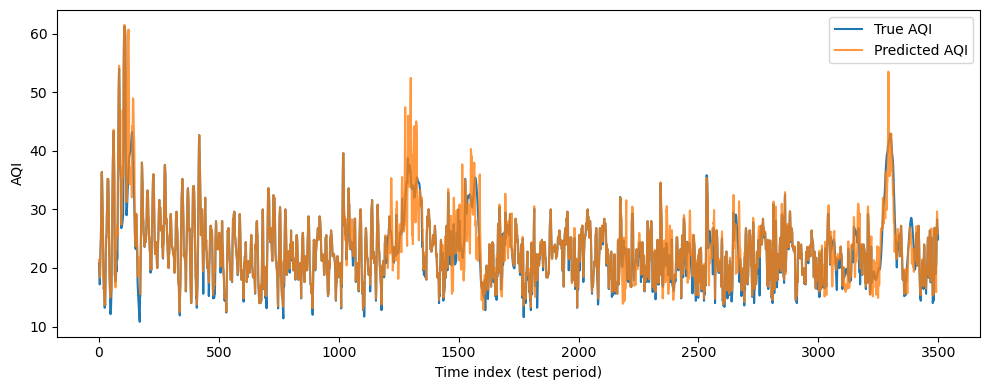

In [14]:
df = london.copy()
df = df.sort_values("Date").reset_index(drop=True)

pollutants = ["CO", "NO2", "SO2", "O3", "PM2.5", "PM10"]
for p in pollutants:
    df[f"{p}_lag1"] = df[p].shift(1)
    df[f"{p}_lag24"] = df[p].shift(24)

df["hour"] = df["Date"].dt.hour
df["day_of_week"] = df["Date"].dt.dayofweek

df = df.dropna().reset_index(drop=True)

feature_cols = (
    pollutants +
    [f"{p}_lag1" for p in pollutants] +
    [f"{p}_lag24" for p in pollutants] +
    ["hour", "day_of_week"]
)

X = df[feature_cols]
y = df["AQI"]

# Chronological split
split_idx = int(0.8 * len(df))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]


model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label="True AQI")
plt.plot(y_pred, label="Predicted AQI", alpha=0.8)
plt.xlabel("Time index (test period)")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()



The feature importance analysis reveals that AQI predictions are primarily driven by ozone levels and lagged particulate matter concentrations, particularly PM2.5. The prominence of 24-hour lag features indicates strong temporal persistence and daily cyclic behaviour in the nature of air pollution. Temporal context variables, such as hour of day, further contribute by capturing emission and dispersion patterns.

In [15]:
importance = pd.Series(
    model.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importance.head(10)

O3             0.293341
PM2.5_lag24    0.275620
PM2.5_lag1     0.110528
PM10_lag1      0.098049
PM10_lag24     0.080406
PM2.5          0.029590
NO2            0.023628
hour           0.020133
O3_lag1        0.011904
CO_lag24       0.009131
dtype: float64

### Supervised time-series classification
Air quality classification is performed using Random Forest Classifier with a strictly enforced chronological data split. AQI is discretized using the 33rd and 66th percentiles into 3 categories (Good, Moderate, Bad). Temporal dependencies are caputured using techniques discussed in the previous section. 

The Random Forest classifier achieved an overall accuracy of 92%, with consistently high precision, recall, and F1-scores across the board. The model demonstrated excellent recall for good air-quality conditions and strong detection of poor air-quality periods, while moderate AQI exhibited slightly lower recall. The balanced macro and weighted performance metrics validate the effectiveness of this classification framework. Also, the confusion matrix shows that the classifier achieves high accuracy across all AQI categories

In [16]:
df = london.copy()
df = df.sort_values("Date").reset_index(drop=True)

q33 = df["AQI"].quantile(0.33)
q66 = df["AQI"].quantile(0.66)

def classify_aqi_quantile(aqi):
    if aqi <= q33:
        return 0  # Good
    elif aqi <= q66:
        return 1  # Moderate
    else:
        return 2  # Bad

df["AQI_class"] = df["AQI"].apply(classify_aqi_quantile)


df["AQI_class"].value_counts(normalize=True)

pollutants = ["CO", "NO2", "SO2", "O3", "PM2.5", "PM10"]
for p in pollutants:
    df[f"{p}_lag1"] = df[p].shift(1)
    df[f"{p}_lag24"] = df[p].shift(24)

df["hour"] = df["Date"].dt.hour
df["day_of_week"] = df["Date"].dt.dayofweek

df = df.dropna().reset_index(drop=True)

feature_cols = (
    pollutants +
    [f"{p}_lag1" for p in pollutants] +
    [f"{p}_lag24" for p in pollutants] +
    ["hour", "day_of_week"]
)

X = df[feature_cols]
y = df["AQI_class"]

# Chronological split
split_idx = int(0.8 * len(df))

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    target_names=["Good", "Moderate", "Bad"]
))



              precision    recall  f1-score   support

        Good       0.91      0.98      0.94      1519
    Moderate       0.95      0.88      0.91      1388
         Bad       0.92      0.90      0.91       593

    accuracy                           0.92      3500
   macro avg       0.92      0.92      0.92      3500
weighted avg       0.93      0.92      0.92      3500



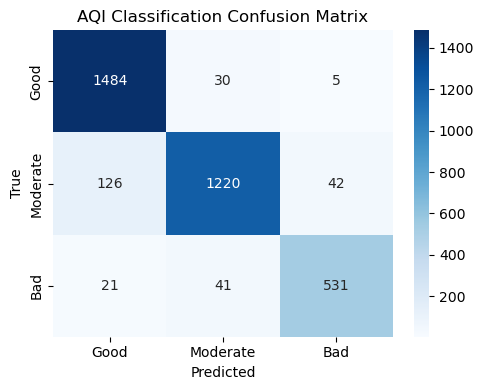

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Good", "Moderate", "Bad"],
    yticklabels=["Good", "Moderate", "Bad"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AQI Classification Confusion Matrix")
plt.tight_layout()
plt.show()

The feature importance analysis reveals that AQI classification is primarily driven by ozone concentration and its short-term temporal persistence, highlighting the dominant role of photochemical pollution in determining air-quality. Lagged particulate matter features further contribute by capturing temporal inertia and daily recurrence patterns, while current PM and NO₂ levels refine class boundaries.

In [18]:
importance = pd.Series(
    clf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

importance.head(10)


O3             0.388059
O3_lag1        0.176510
PM2.5_lag24    0.058149
PM2.5_lag1     0.050624
NO2            0.045235
PM2.5          0.040764
O3_lag24       0.035149
PM10_lag24     0.029378
PM10_lag1      0.029148
PM10           0.025902
dtype: float64